<a href="https://colab.research.google.com/github/dolmani38/NOTAM/blob/main/albert_notam_model_1024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Albert NOTAM 언어 모델 학습!

In [1]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## 참조

https://colab.research.google.com/github/parmarsuraj99/suraj-parmar/blob/master/_notebooks/2020-05-02-SanskritALBERT.ipynb#scrollTo=VNAOMXjpMHZD


In [1]:
import os
import gc
import glob
import torch
import pickle
import joblib
from tqdm.auto import tqdm

In [2]:
!git clone https://github.com/huggingface/transformers
!pip install transformers/.
!pip install sentencepiece==0.1.95
!pip install datasets==1.8.0

fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.12.0.dev0-py3-none-any.whl size=2994301 sha256=67540090520f3b138da9baaa44eff846208bbd0837c08486ab165deb15458016
  Stored in directory: /tmp/pip-ephem-wheel-cache-xcxad049/wheels/49/62/f4/6730819eed4e6468662b1519bf3bf46419b2335990c77f8767
Successfully built transformers
  Attempting uninstall: transformers
  

# NOTAM Dataset load

In [2]:
%%time

import re
import pandas as pd
import sys

df = pd.read_csv('/content/drive/MyDrive/NOTAM/data/TRAIN_20210928.csv')


CPU times: user 70.3 ms, sys: 16.1 ms, total: 86.4 ms
Wall time: 90.6 ms


In [3]:
df

,MSG_ID,UPDATED_BY,UPDATED_DATE,E_SCORE,AE_SCORE,ALL_SCORE,Q_LINE,A_LINE,B_LINE,C_LINE,D_LINE,E_LINE
0,6231155,shbl1021,2021-09-16 11:02,3,2,2,PAZA/QMNXX////000/999/6449N14751W005,PAFA,1902140120,1902150120,NaN,SOUTH TERMINAL RAMP \nICE AND 1/8IN DRY SN OVE...
1,6824038,parkij,2021-07-01 8:16,0,0,0,YUXX/QOAXX/IV/BO/E/000/999/2537S13421E005,YBBB/YMMM,1905221600,1906191600,NaN,AIS (XX)\nAUSTRALIAN DIGITAL AERONAUTICAL FLIG...
2,6824038,shbl1021,2021-06-08 9:08,1,1,1,YUXX/QOAXX/IV/BO/E/000/999/2537S13421E005,YBBB/YMMM,1905221600,1906191600,NaN,AIS (XX)\nAUSTRALIAN DIGITAL AERONAUTICAL FLIG...
3,6816851,parkij,2021-07-01 8:18,5,5,0,LECM/QRDCA/IV/BO /W /000/100/3635N00636W022,LECM,1905270600,1905301559,"27-28 0600-1900, 30 1201-1559",LED128 ACTIVATED. LOWER AND UPPER VERTICAL LIM...
4,6816851,shbl1021,2021-06-08 9:09,5,5,2,LECM/QRDCA/IV/BO /W /000/100/3635N00636W022,LECM,1905270600,1905301559,"27-28 0600-1900, 30 1201-1559",LED128 ACTIVATED. LOWER AND UPPER VERTICAL LIM...
...,...,...,...,...,...,...,...,...,...,...,...,...
23714,15947262,shbl1021,2021-08-10 16:06,1,1,1,LCCC/QWFLW/IV/M /W /210/230/3335N03202E133,LCCC,2001040820,2001051150,0820-1150,AIR REFUELLING WILL TAKE PLACE ALONG \nSUVAS-K...
23715,15962821,shbl1021,2021-08-10 16:48,5,4,4,KZAU/QMRLC/IV/NBO/A/000/999/4257N08754W005,KMKE,1912310929,2001012359,NaN,RWY 01L/19R CLSD
23716,15964683,shbl1021,2021-09-17 17:00,3,2,2,KZOB/QMXXX////000/999/4213N08321W005,KDTW,1912311140,2001011140,NaN,TWY ALL 1/4IN DRY SN OBS AT 1912311140.
23717,15965583,shbl1021,2021-08-06 13:52,4,4,3,RJJJ/QMXLC/IV/M/A/000/999/3533N13947E005,RJTT,2001071500,2001072000,NaN,TWY H(BTN E AND W) H1 H2 R(BTN H AND G)-CLSD D...


In [4]:
# if nugu =='shbl1021' and date1 >= '2021-07-09 00:00':

df1 = df[df['UPDATED_BY'] == 'shbl1021'][df['UPDATED_DATE'] >= '2021-07-09 00:00'][df['AE_SCORE'] > 0]
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,MSG_ID,UPDATED_BY,UPDATED_DATE,E_SCORE,AE_SCORE,ALL_SCORE,Q_LINE,A_LINE,B_LINE,C_LINE,D_LINE,E_LINE
0,6231155,shbl1021,2021-09-16 11:02,3,2,2,PAZA/QMNXX////000/999/6449N14751W005,PAFA,1902140120,1902150120,NaN,SOUTH TERMINAL RAMP \nICE AND 1/8IN DRY SN OVE...
11,6816735,shbl1021,2021-09-18 15:31,5,5,4,LECM/QRDCA/IV/BO /W /000/100/3606N00702W022,LECM,1905270600,1905311900,"27-28 31 0600-1900, 29 0600-0830 1200-1600, 30...",LED122 ACTIVATED. UPPER VERTICAL LIMIT MODIFIED
16,5502755,shbl1021,2021-09-18 9:22,1,1,1,KZAU/QMRXX////000/999/4158N08754W005,KORD,1901021632,1901031632,NaN,RWY 27L 5/5/5 100 PCT WET DEICED LIQUID \nOBS ...
26,5537714,shbl1021,2021-09-18 11:24,3,2,2,PAZA/QMXXX////000/999/6449N14751W005,PAFA,1901041643,1901051643,NaN,"TWY C, D COMPACTED SN 30IN BERMS OBS AT 190104..."
27,5554972,shbl1021,2021-09-16 11:33,2,2,2,LKAA/QFDAS/I/M/A/000/999/5006N01416E005,LKPR,1901051740,1901071100,NaN,VISUAL GUIDANCE DOCKING SYSTEM APIS ON STAND 2...
...,...,...,...,...,...,...,...,...,...,...,...,...
23714,15947262,shbl1021,2021-08-10 16:06,1,1,1,LCCC/QWFLW/IV/M /W /210/230/3335N03202E133,LCCC,2001040820,2001051150,0820-1150,AIR REFUELLING WILL TAKE PLACE ALONG \nSUVAS-K...
23715,15962821,shbl1021,2021-08-10 16:48,5,4,4,KZAU/QMRLC/IV/NBO/A/000/999/4257N08754W005,KMKE,1912310929,2001012359,NaN,RWY 01L/19R CLSD
23716,15964683,shbl1021,2021-09-17 17:00,3,2,2,KZOB/QMXXX////000/999/4213N08321W005,KDTW,1912311140,2001011140,NaN,TWY ALL 1/4IN DRY SN OBS AT 1912311140.
23717,15965583,shbl1021,2021-08-06 13:52,4,4,3,RJJJ/QMXLC/IV/M/A/000/999/3533N13947E005,RJTT,2001071500,2001072000,NaN,TWY H(BTN E AND W) H1 H2 R(BTN H AND G)-CLSD D...


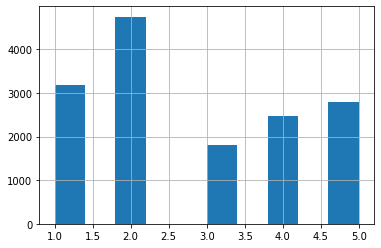

In [5]:
df1['AE_SCORE'].hist()

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/NOTAM/data/TRAIN_SET_2019.csv')
df2

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,MSG_ID,Q_ICAO_CODE,Q_CODE,Q_LINE,A_LINE,B_LINE,C_LINE,D_LINE,E_LINE,F_LINE,G_LINE,CREATED_DATE
0,11970570,EVRR,QWBLW,EVRR/QWBLW/IV/M /W /015/080/5648N02431E002,EVRR,1.90531e+09,1905311800,NaN,AEROBATIC FLIGHT TRAINING WILL TAKE PLACE\nIN ...,1500FT AMSL,FL080,2019-05-30 19:56
1,9666169,EDGG,QSTCF,EDGG/QSTCF/IV/BO /A /000/999/4841N00913E005,EDDS,1.90502e+09,1905030500EST,NaN,STUTTGART TWR FREQ 119.050MHZ OUT OF SERVICE. ...,NaN,NaN,2019-05-03 1:46
2,9500003,URRV,QRRCA,URRV/QRRCA/IV/BO/W/000/490/4847N04348E010,URRV,1.90501e+09,1905312359,NaN,RESTRICTED AREA ACT: URR523.,GND,FL490,2019-04-25 11:37
3,14017186,EVRR,QRRCA,EVRR/QRRCA/IV/BO /W /000/025/5634N02333E004,EVRR,1.90918e+09,1909182200,NaN,RESTRICTED AREA EVR15 ZALENIEKI ACT FOR UNMANN...,GND,2500FT AMSL,2019-09-17 19:34
4,9827869,KZME,QMRXX,KZME/QMRXX////000/999/3438N08647W005,KHSV,1.90511e+09,1905122232,NaN,RWY 18L 5/5/5 100 PCT WET OBS AT 1905112232. C...,NaN,NaN,2019-05-12 7:39
...,...,...,...,...,...,...,...,...,...,...,...,...
610385,13808174,KZDV,QMXXX,KZDV/QMXXX////000/999/3952N10440W005,KDEN,1909060129,1909070129,NaN,TWY ALL WET OBS AT 1909060129.,NaN,NaN,2019-09-06 10:36
610386,12658425,KZFW,QMRXX,KZFW/QMRXX////000/999/3254N09702W005,KDFW,1907070142,1907080142,NaN,RWY 17C 5/5/5 100 PCT WET OBS AT 1907070141.,NaN,NaN,2019-07-07 10:49
610387,10064108,ENOR,QRDCA,ENOR/QRDCA/IV/BO /W /000/040/5806N00638E002,ENOR,1906170900,1906231900,NaN,DANGER AREA END257 AWES LISTA ACTIVATED. FOR C...,GND,4000FT AMSL,2019-05-31 15:57
610388,14251481,WAAF,QWULW,WAAF/QWULW/IV/BO/W/000/007/0738S11257E002,WAAF,1910010100,1910061000,DLY 0100-1000,UNMANNED AERIAL VEHICLE (UAV) WILL TAKE PLACE ...,GND,700FT AGL,2019-09-30 11:42


In [6]:

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    #txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    #txt = txt.replace('..','')
    #txt = txt.replace('...','')
    #txt = txt.replace('.','. ')
    #txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

In [ ]:
notam_contents = []

for row in df.iterrows():
    doc_cont = str(row[1][11])
    # Q Section
    notam_contents.append(clean_text(str(row[1][6]).lower()))
    # A Section
    notam_contents.append(clean_text(str(row[1][7]).lower()))
    # E Section
    notam_contents.append(clean_text(doc_cont.lower()))

for row in df2.iterrows():
    doc_cont = str(row[1][8])
    # Q Section
    notam_contents.append(clean_text(str(row[1][3]).lower()))
    # A Section
    notam_contents.append(clean_text(str(row[1][4]).lower()))
    # E Section
    notam_contents.append(clean_text(doc_cont.lower()))    

In [ ]:
len(notam_contents)

1862415

In [ ]:
notam_contents[2]

'ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.'

In [ ]:
f = open('/content/drive/MyDrive/NOTAM/train_tokenizer3.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    notam_contents.append(clean_text(line.lower()))
f.close()

FileNotFoundError: ignored

In [ ]:
len(notam_contents)

1862415

In [ ]:
%%time
# subword 학습을 위해 문장만 따로 저장
with open('/content/drive/MyDrive/NOTAM/train_tokenizer.txt', 'w', encoding='utf-8') as f:
    for line in notam_contents:
        f.write(line+'\n')

f.close()

CPU times: user 695 ms, sys: 105 ms, total: 800 ms
Wall time: 1.35 s


# Tokenizer 학습


In [ ]:
%%time
import sentencepiece as spm
import os
# spm_train --input=data/train_tokenizer.txt  --model_prefix=sentencepiece/sp --vocab_size=32000 character_coverage=1.0 --model_type="unigram"

input_file = '/content/drive/MyDrive/NOTAM/train_tokenizer.txt'
vocab_size = 32000

sp_model_root='/content/drive/MyDrive/NOTAM/albert_tokenizer_model'
if not os.path.isdir(sp_model_root):
    os.mkdir(sp_model_root)
sp_model_name = 'spiece'
sp_model_path = os.path.join(sp_model_root, sp_model_name)
model_type = 'unigram'  # 학습할 모델 선택, unigram이 더 성능이 좋음'bpe'
character_coverage  = 1.0  # 전체를 cover 하기 위해, default=0.9995
user_defined_symbols = '[PAD],[UNK],[CLS],[SEP],[MASK],[BOS],[EOS],[UNK0],[UNK1],[UNK2],[UNK3],[UNK4],[UNK5],[UNK6],[UNK7],[UNK8],[UNK9],[unused0],[unused1],[unused2],[unused3],[unused4],[unused5],[unused6],[unused7],[unused8],[unused9],[unused10],[unused11],[unused12],[unused13],[unused14],[unused15],[unused16],[unused17],[unused18],[unused19],[unused20],[unused21],[unused22],[unused23],[unused24],[unused25],[unused26],[unused27],[unused28],[unused29],[unused30],[unused31],[unused32],[unused33],[unused34],[unused35],[unused36],[unused37],[unused38],[unused39],[unused40],[unused41],[unused42],[unused43],[unused44],[unused45],[unused46],[unused47],[unused48],[unused49],[unused50],[unused51],[unused52],[unused53],[unused54],[unused55],[unused56],[unused57],[unused58],[unused59],[unused60],[unused61],[unused62],[unused63],[unused64],[unused65],[unused66],[unused67],[unused68],[unused69],[unused70],[unused71],[unused72],[unused73],[unused74],[unused75],[unused76],[unused77],[unused78],[unused79],[unused80],[unused81],[unused82],[unused83],[unused84],[unused85],[unused86],[unused87],[unused88],[unused89],[unused90],[unused91],[unused92],[unused93],[unused94],[unused95],[unused96],[unused97],[unused98],[unused99]'

input_argument = '--input=%s --model_prefix=%s --vocab_size=%s --user_defined_symbols=%s --model_type=%s --character_coverage=%s'
cmd = input_argument%(input_file, sp_model_path, vocab_size,user_defined_symbols, model_type, character_coverage)

spm.SentencePieceTrainer.Train(cmd)
print('train done')

train done
CPU times: user 2min 29s, sys: 1.65 s, total: 2min 30s
Wall time: 1min 47s


In [ ]:
## check
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(sp_model_path))

tokens = sp.encode_as_pieces("ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.")
ids = sp.encode_as_ids("ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.")

print(ids)
print(tokens)

tokens = sp.decode_pieces(tokens)
ids = sp.decode_ids(ids)

print(ids)
print(tokens)

[1826, 156, 149, 154, 516, 121, 129, 8596, 2815, 139, 531, 372, 1914, 5957, 597, 156, 397, 128, 173, 122, 1783, 407, 2897, 597, 154, 1193, 127, 9230, 7439, 516, 121, 129, 8596, 2815, 139, 531, 372, 1914, 5957, 597, 7439, 228, 156, 397, 128, 173, 122, 1783, 407, 2897, 597, 377, 764, 487, 381, 1826, 148, 122, 407, 648, 143, 122, 121, 123, 177, 127, 226, 343, 328, 127]
['▁ais', '▁(', 'xx', ')', '▁australia', 'n', '▁', 'digital', '▁aeronautica', 'l', '▁flight', '▁information', '▁file', '▁edition', '▁8', '▁(', 'au', 's', 'd', 'a', 'fi', 'f', '▁ed', '▁8', ')', '▁withdrawn', '.', '▁replacement', '▁version', '▁australia', 'n', '▁', 'digital', '▁aeronautica', 'l', '▁flight', '▁information', '▁file', '▁edition', '▁8', '▁version', '▁2', '▁(', 'au', 's', 'd', 'a', 'fi', 'f', '▁ed', '▁8', '▁v', '2)', '▁available', '▁via', '▁ais', '-', 'a', 'f', '▁int', 'r', 'a', 'n', 'e', 't', '.', '▁mil', '▁use', '▁only', '.']
ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 

# 여기서부터 다시 -> NOTAM Language model 만들기...

In [ ]:
## 1) define special tokens
user_defined_symbols = ['[BOS]','[EOS]','[UNK0]','[UNK1]','[UNK2]','[UNK3]','[UNK4]','[UNK5]','[UNK6]','[UNK7]','[UNK8]','[UNK9]']
unused_token_num = 200
unused_list = ['[unused{}]'.format(n) for n in range(unused_token_num)]
user_defined_symbols = user_defined_symbols + unused_list

print(user_defined_symbols)

['[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused6

In [ ]:
from transformers import AlbertTokenizer, AlbertTokenizerFast

#'/content/drive/MyDrive/Tokenizer_train/albert_tokenizer_model'

albet_tokenizer_model = '/content/drive/MyDrive/NOTAM/albert_tokenizer_model'

tokenizer = AlbertTokenizerFast.from_pretrained(albet_tokenizer_model)


file /content/drive/MyDrive/NOTAM/albert_tokenizer_model/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
file /content/drive/MyDrive/NOTAM/albert_tokenizer_model/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
op = tokenizer.encode("ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.")
print(op)
tokenizer.decode(op)


[5, 1826, 156, 149, 154, 516, 121, 129, 8596, 2815, 139, 531, 372, 1914, 5957, 597, 156, 397, 128, 173, 122, 1783, 407, 2897, 597, 154, 1193, 127, 9230, 7439, 516, 121, 129, 8596, 2815, 139, 531, 372, 1914, 5957, 597, 7439, 228, 156, 397, 128, 173, 122, 1783, 407, 2897, 597, 377, 764, 487, 381, 1826, 148, 122, 407, 648, 143, 122, 121, 123, 177, 127, 226, 343, 328, 127, 6]


'[CLS] ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.[SEP]'

In [ ]:
# tokenizer에 special token 추가
special_tokens_dict = {'additional_special_tokens': user_defined_symbols}
tokenizer.add_special_tokens(special_tokens_dict)

# check tokenizer vocab with special tokens
print('check special tokens : %s'%tokenizer.all_special_tokens[:20])

check special tokens : ['[CLS]', '[SEP]', '<unk>', '<pad>', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']


In [ ]:
# save tokenizer model with special tokens
tokenizer.save_pretrained(albet_tokenizer_model+'_special')

('/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/tokenizer_config.json',
 '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/special_tokens_map.json',
 '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/spiece.model',
 '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/added_tokens.json',
 '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/tokenizer.json')

In [ ]:
from transformers import AlbertTokenizer, AlbertTokenizerFast

tokenizer = AlbertTokenizer.from_pretrained(albet_tokenizer_model+'_special')

In [ ]:
op = tokenizer("ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.", return_tensors="pt")
print(op)
print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in op['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(op['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(op['attention_mask'].tolist()[0]))


{'input_ids': tensor([[   5, 1826,  156,  149,  154,  516,  121,  129, 8596, 2815,  139,  531,
          372, 1914, 5957,  597,  156,  397,  128,  173,  122, 1783,  407, 2897,
          597,  154, 1193,  127, 9230, 7439,  516,  121,  129, 8596, 2815,  139,
          531,  372, 1914, 5957,  597, 7439,  228,  156,  397,  128,  173,  122,
         1783,  407, 2897,  597,  377,  764,  487,  381, 1826,  148,  122,  407,
          648,  143,  122,  121,  123,  177,  127,  226,  343,  328,  127,    6]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
#Checking vocabulary size
vocab_size=tokenizer.vocab_size ; vocab_size

32000

In [ ]:
import json

config = {
    "architectures": [
        "AlbertModel"
    ],
	"attention_probs_dropout_prob": 0.1,
	"hidden_act": "gelu",
	"hidden_dropout_prob": 0.1,
	"hidden_size": 768,
	"initializer_range": 0.02,
	"intermediate_size": 3072,
	"layer_norm_eps": 1e-05,
	"max_position_embeddings": 514,
	"model_type": "albert",
	"num_attention_heads": 12,
	"num_hidden_layers": 6,
	"type_vocab_size": 1,
	"vocab_size": vocab_size
}
with open(albet_tokenizer_model + "_special/config.json", 'w') as fp:
    json.dump(config, fp)


#Configuration for tokenizer.
#Note: I set do_lower_case: False, and keep_accents:True
# Opening JSON file
f = open(albet_tokenizer_model+ "_special/tokenizer_config.json")
   
# returns JSON object as 
# a dictionary
tokenizer_config = json.load(f)

tokenizer_config['max_len'] = 512
tokenizer_config['model_type'] = 'albert'
tokenizer_config['do_lower_case'] = False
tokenizer_config['keep_accents'] = True

with open(albet_tokenizer_model+ "_special/tokenizer_config.json", 'w') as outfile:
    json.dump(tokenizer_config, outfile)
'''
tokenizer_config = {
	"max_len": 512,
	"model_type": "albert",
	"do_lower_case":False, 
	"keep_accents":True
}
with open(albet_tokenizer_model+ "_special/tokenizer_config.json", 'w') as fp:
    json.dump(tokenizer_config, fp)
'''

'\ntokenizer_config = {\n\t"max_len": 512,\n\t"model_type": "albert",\n\t"do_lower_case":False, \n\t"keep_accents":True\n}\nwith open(albet_tokenizer_model+ "_special/tokenizer_config.json", \'w\') as fp:\n    json.dump(tokenizer_config, fp)\n'

In [ ]:

#To train from scratch
!python /content/transformers/examples/pytorch/language-modeling/run_mlm.py \
        --model_type albert-base-v2 \
        --config_name /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special \
        --tokenizer_name /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special \
        --train_file /content/drive/MyDrive/NOTAM/train_tokenizer.txt \
        --output_dir /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model \
        --use_fast_tokenizer \
        --do_train \
        --line_by_line \
        --save_steps 100000 \
        --logging_steps 100000 \
        --save_total_limit 2 \
        --num_train_epochs 10 \
        --seed 108 \
        --overwrite_output_dir \
        --logging_dir /content/drive/MyDrive/Tokenizer_train/logs

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[INFO|trainer.py:2013] 2021-09-13 11:33:50,264 >> Deleting older checkpoint [/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model/checkpoint-61500] due to args.save_total_limit
{'loss': 2.7488, 'learning_rate': 4.928785234353099e-05, 'epoch': 0.28}
  1% 63000/4423240 [1:39:02<86:35:07, 13.99it/s][INFO|trainer.py:1937] 2021-09-13 11:34:36,778 >> Saving model checkpoint to /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model/checkpoint-63000
[INFO|configuration_utils.py:404] 2021-09-13 11:34:36,785 >> Configuration saved in /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model/checkpoint-63000/config.json
[INFO|modeling_utils.py:1001] 2021-09-13 11:34:36,983 >> Model weights saved in /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model/checkpoint-63000/pytorch_model.bin
[INFO|tokenization_utils_base.py:2022] 2021-09-13 11:34:36,991 >> tokenizer config file saved in /content/drive/MyDrive/NOTAM/albert_t

# language model 만들었으면... 여기서 부터~

In [7]:
model_name = 'albert-base-v2'
#model_name = 'albert-large-v2'
#model_name = 'albert-xlarge-v2'
#model_name = 'albert-xxlarge-v2'
#model_name = '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model'

In [8]:
from transformers import AlbertTokenizer, AlbertTokenizerFast

tokenizer = AlbertTokenizer.from_pretrained(model_name)
op = tokenizer("ais (xx) australian digital aeronautical flight information file edition 8 (ausdafif ed 8) withdrawn. replacement version australian digital aeronautical flight information file edition 8 version 2 (ausdafif ed 8 v2) available via ais-af intranet. mil use only.", return_tensors="pt")
print(op)
print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in op['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(op['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(op['attention_mask'].tolist()[0]))

{'input_ids': tensor([[    2,    21,   403,    13,     5,  8962,     6,   933,  1888, 26976,
          1690,   676,  3893,  1322,   469,    13,     5,  1346,    18,    43,
          2565,   821,    13,    69,   469,     6,  9682,     9,  4610,   615,
           933,  1888, 26976,  1690,   676,  3893,  1322,   469,   615,   172,
            13,     5,  1346,    18,    43,  2565,   821,    13,    69,   469,
           566,   135,     6,   904,  1197,    21,   403,     8,  2565, 14369,
          2328,     9,  7097,   275,   104,     9,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1

# Albert NOTAM Classification Model class

In [14]:
import os
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
import time
import random
import datetime
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split


class Notam_classification_model:
    def __init__(self,pre_trained_model_name='albert-base-v2'):
        self.tokenizer = AlbertTokenizer.from_pretrained(pre_trained_model_name)
        self.model  = AlbertForSequenceClassification.from_pretrained(
                                    pre_trained_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 5, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )
        # If there's a GPU available...
        if torch.cuda.is_available():    

            # Tell PyTorch to use the GPU.    
            self.device = torch.device("cuda")

            print('There are %d GPU(s) available.' % torch.cuda.device_count())

            print('We will use the GPU:', torch.cuda.get_device_name(0))

        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            self.device = torch.device("cpu")

    def __clean_text(self,txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        #txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        #txt = txt.replace('..','')
        #txt = txt.replace('...','')
        #txt = txt.replace('.','. ')
        #txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')             
        return txt.strip()        

    # Function to calculate the accuracy of our predictions vs labels
    def __flat_accuracy(self,preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    def __format_time(self,elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        
        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))

    def save_notam_model(self, output_dir = '/content/drive/MyDrive/NOTAM/notam_model'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

    def load_notam_model(self,input_dir = '/content/drive/MyDrive/NOTAM/notam_model/For_E_Section'):
        print('Loading Albert notam model...')
        self.tokenizer = AlbertTokenizer.from_pretrained(input_dir)
        self.model = AlbertForSequenceClassification.from_pretrained(input_dir)
        #self.tokenizer.to(self.device)
        self.model.to(self.device)

    def get_train_dataset(self,data_frame,section='E',batch_size=96):
        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []
        labels = []
        # For every sentence...
        for row in data_frame.iterrows():

            if section=='E':
                # E section
                sent = self.__clean_text(str(row[1][11]).lower()) 
                # label for E Section
                lb = row[1][3]-1
            elif section=='AE':
                # A section
                sent = self.__clean_text(str(row[1][7]).lower())     
                # E section
                sent = sent + ' [SEP] ' + self.__clean_text(str(row[1][11]).lower()) 
                # label for AE_score
                lb = row[1][4]-1                

            labels.append(lb)
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 128,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print("Tokens (str)      : {}".format([self.tokenizer.convert_ids_to_tokens(s) for s in input_ids[0].tolist()]))
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        #batch_size = 64+32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = batch_size # Evaluate with this batch size.
                )
        return train_dataloader,validation_dataloader        


    def train(self,epochs=1,train_dataloader=None,validation_dataloader=None,output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_E_Section'):

        # Tell pytorch to run this model on the GPU.
        self.model.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.model.named_parameters())

        print('The Albert model has {:} different named parameters.\n'.format(len(params)))
        
        print(self.model)

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        optimizer = AdamW(self.model.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.model.train()

            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = self.__format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(self.device)
                b_input_mask = batch[1].to(self.device)
                b_labels = batch[2].to(self.device)

                #print(b_input_ids)
                #print(b_input_mask)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.

                outputs = self.model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                '''
                loss, logits = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                '''
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                loss = outputs[0]
                logits = outputs[1]
                
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = self.__format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))

            avg_val_loss, avg_val_accuracy, validation_time = self.validate(validation_dataloader)
            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )


        self.save_notam_model(output_dir)
        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(self.__format_time(time.time()-total_t0)))

        return training_stats

    def validate(self,validation_dataloader=None):          
        true_labels = []
        pred_labels = []
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)
            for l in batch[2]:
                true_labels.append(l.item())        
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = self.model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]            
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            for li in logits:
                pred_labels.append(np.argmax(li))
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += self.__flat_accuracy(logits, label_ids)
            
        print("  classification_report   ")    
        print(classification_report(true_labels,pred_labels))
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = self.__format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        return avg_val_loss, avg_val_accuracy, validation_time


      


In [12]:
ancm = Notam_classification_model(pre_trained_model_name='albert-base-v2')
train_dataloader,validation_dataloader = ancm.get_train_dataset(df1)
ancm.train(epochs=10, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_E_Section')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Tokens (str)      : ['[CLS]', '▁south', '▁terminal', '▁ramp', '▁ice', '▁and', '▁1', '/8', 'in', '▁dry', '▁sn', '▁over', '▁compact', 'ed', '▁sn', '▁ob', 's', '▁at', '▁1902', '140', '120', '.', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

[{'Training Loss': 0.7205787495518408,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8498697916666667,
  'Valid. Loss': 0.44691540487110615,
  'Validation Time': '0:00:06',
  'epoch': 1},
 {'Training Loss': 0.32573863361955535,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8979166666666667,
  'Valid. Loss': 0.3235158659517765,
  'Validation Time': '0:00:06',
  'epoch': 2},
 {'Training Loss': 0.2449863871149983,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8981770833333335,
  'Valid. Loss': 0.33011379186064005,
  'Validation Time': '0:00:06',
  'epoch': 3},
 {'Training Loss': 0.20047799571820185,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.9069010416666666,
  'Valid. Loss': 0.2903577387332916,
  'Validation Time': '0:00:06',
  'epoch': 4},
 {'Training Loss': 0.16196355007007612,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.9003906250000001,
  'Valid. Loss': 0.32191570289433,
  'Validation Time': '0:00:06',
  'epoch': 5},
 {'Training Loss': 0.132580993261109,

In [15]:
del ancm
ancm = Notam_classification_model(pre_trained_model_name='albert-base-v2')
train_dataloader,validation_dataloader = ancm.get_train_dataset(df1,section='AE')
ancm.train(epochs=10, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_AE_Section')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Tokens (str)      : ['[CLS]', '▁pa', 'fa', '[SEP]', '▁south', '▁terminal', '▁ramp', '▁ice', '▁and', '▁1', '/8', 'in', '▁dry', '▁sn', '▁over', '▁compact', 'ed', '▁sn', '▁ob', 's', '▁at', '▁1902', '140', '120', '.', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

[{'Training Loss': 0.9304313837213719,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.6537760416666666,
  'Valid. Loss': 0.9328352734446526,
  'Validation Time': '0:00:06',
  'epoch': 1},
 {'Training Loss': 0.6426334398012634,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8143229166666668,
  'Valid. Loss': 0.5385270863771439,
  'Validation Time': '0:00:06',
  'epoch': 2},
 {'Training Loss': 0.45979171293847104,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8446614583333333,
  'Valid. Loss': 0.4472093414515257,
  'Validation Time': '0:00:06',
  'epoch': 3},
 {'Training Loss': 0.36082044888472725,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8598958333333333,
  'Valid. Loss': 0.4233703427016735,
  'Validation Time': '0:00:06',
  'epoch': 4},
 {'Training Loss': 0.29603947757195076,
  'Training Time': '0:02:42',
  'Valid. Accur.': 0.8688802083333335,
  'Valid. Loss': 0.39885253738611937,
  'Validation Time': '0:00:06',
  'epoch': 5},
 {'Training Loss': 0.255377335381423

In [16]:
del ancm
ancm = Notam_classification_model(pre_trained_model_name='/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model')
train_dataloader,validation_dataloader = ancm.get_train_dataset(df1,section='E')
ancm.train(epochs=10, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_E_Section_nl')

Some weights of the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tok

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Tokens (str)      : ['[CLS]', '▁south', '▁terminal', '▁ramp', '▁ice', '▁and', '▁1/8', 'in', '▁dry', '▁sn', '▁over', '▁compact', 'ed', '▁sn', '▁obs', '▁at', '▁1902140', '120.', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

[{'Training Loss': 1.075042577288675,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.8330729166666667,
  'Valid. Loss': 0.48677776008844376,
  'Validation Time': '0:00:03',
  'epoch': 1},
 {'Training Loss': 0.3756597836812337,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.8772135416666665,
  'Valid. Loss': 0.3564295740798116,
  'Validation Time': '0:00:03',
  'epoch': 2},
 {'Training Loss': 0.2761236278089226,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.8984375000000001,
  'Valid. Loss': 0.30447534564882517,
  'Validation Time': '0:00:03',
  'epoch': 3},
 {'Training Loss': 0.22542424542261352,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.9122395833333333,
  'Valid. Loss': 0.28700374998152256,
  'Validation Time': '0:00:03',
  'epoch': 4},
 {'Training Loss': 0.20067367105619283,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.912890625,
  'Valid. Loss': 0.2767715398222208,
  'Validation Time': '0:00:03',
  'epoch': 5},
 {'Training Loss': 0.18361326235722988,
  '

In [17]:
del ancm
ancm = Notam_classification_model(pre_trained_model_name='/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model')
train_dataloader,validation_dataloader = ancm.get_train_dataset(df1,section='AE')
ancm.train(epochs=10, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_AE_Section_nl')

Some weights of the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tok

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Tokens (str)      : ['[CLS]', '▁paf', 'a', '[SEP]', '▁south', '▁terminal', '▁ramp', '▁ice', '▁and', '▁1/8', 'in', '▁dry', '▁sn', '▁over', '▁compact', 'ed', '▁sn', '▁obs', '▁at', '▁1902140', '120.', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

[{'Training Loss': 1.2043506291741175,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.7231770833333334,
  'Valid. Loss': 0.729401808232069,
  'Validation Time': '0:00:03',
  'epoch': 1},
 {'Training Loss': 0.5891011748330813,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.7973958333333333,
  'Valid. Loss': 0.5610933862626553,
  'Validation Time': '0:00:03',
  'epoch': 2},
 {'Training Loss': 0.47209966077026744,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.827734375,
  'Valid. Loss': 0.49674419686198235,
  'Validation Time': '0:00:03',
  'epoch': 3},
 {'Training Loss': 0.40013058314509425,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.8446614583333333,
  'Valid. Loss': 0.4483519736677408,
  'Validation Time': '0:00:03',
  'epoch': 4},
 {'Training Loss': 0.35701900033663353,
  'Training Time': '0:01:13',
  'Valid. Accur.': 0.8584635416666667,
  'Valid. Loss': 0.41387889534235,
  'Validation Time': '0:00:03',
  'epoch': 5},
 {'Training Loss': 0.3225482592345975,
  'Trai

# albert_base_v2 + notam languge mode

In [32]:
from transformers import AlbertModel
import torch.nn.functional as F

class AL_NL_Model(nn.Module):

    def __init__(self):
        super().__init__()
        al_pre_trained_model = 'albert-base-v2'
        nl_pre_trained_model = '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model'
        
        #self.al_tokenizer = AlbertTokenizer.from_pretrained(al_pre_trained_model)
        #self.nl_tokenizer = AlbertTokenizer.from_pretrained(nl_pre_trained_model)
        self.al_bert = AlbertModel.from_pretrained(al_pre_trained_model, return_dict=True)
        self.nl_bert = AlbertModel.from_pretrained(nl_pre_trained_model, return_dict=True)
        
        self.classifier = nn.Linear(self.al_bert.config.hidden_size + self.nl_bert.config.hidden_size, 5)
        self.criterion = nn.CrossEntropyLoss()

        #BCEWithLogitsLoss

    def forward(self, input_ids, attention_mask,n_input_ids, n_attention_mask,labels):
        #ta = torch.tensor(np.eye(self.a_mapping_classes, dtype='uint8')[a_mapping])
        #ta = F.one_hot(a_mapping, num_classes=self.a_mapping_classes).float()
        output1 = self.al_bert(input_ids, attention_mask=attention_mask)
        output2 = self.nl_bert(n_input_ids, attention_mask=n_attention_mask)
        
        output = self.classifier(torch.cat((output1.pooler_output,output2.pooler_output),1))
        #output = torch.softmax(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return [loss, output]

In [33]:
mm = AL_NL_Model()
print(mm)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions

AL_NL_Model(
  (al_bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
       

In [36]:

class Notam_classification_model2:
    def __init__(self):
        al_pre_trained_model = 'albert-base-v2'
        nl_pre_trained_model = '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model'
        
        self.al_tokenizer = AlbertTokenizer.from_pretrained(al_pre_trained_model)
        self.nl_tokenizer = AlbertTokenizer.from_pretrained(nl_pre_trained_model)
        self.model  = AL_NL_Model()
        # If there's a GPU available...
        if torch.cuda.is_available():    

            # Tell PyTorch to use the GPU.    
            self.device = torch.device("cuda")

            print('There are %d GPU(s) available.' % torch.cuda.device_count())

            print('We will use the GPU:', torch.cuda.get_device_name(0))

        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            self.device = torch.device("cpu")

    def __clean_text(self,txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        #txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        #txt = txt.replace('..','')
        #txt = txt.replace('...','')
        #txt = txt.replace('.','. ')
        #txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')             
        return txt.strip()        

    # Function to calculate the accuracy of our predictions vs labels
    def __flat_accuracy(self,preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    def __format_time(self,elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        
        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))

    def save_notam_model(self, output_dir = '/content/drive/MyDrive/NOTAM/notam_model'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model  # Take care of distributed/parallel training
        #model_to_save.save_pretrained(output_dir)
        #self.tokenizer.save_pretrained(output_dir)

    def load_notam_model(self,input_dir = '/content/drive/MyDrive/NOTAM/notam_model/For_E_Section'):
        print('Loading dual notam model...')
        al_pre_trained_model = 'albert-base-v2'
        nl_pre_trained_model = '/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model'
        
        self.al_tokenizer = AlbertTokenizer.from_pretrained(al_pre_trained_model)
        self.nl_tokenizer = AlbertTokenizer.from_pretrained(nl_pre_trained_model)

        self.model = AL_NL_Model.from_pretrained(input_dir)
        #self.tokenizer.to(self.device)
        self.model.to(self.device)

    def get_train_dataset(self,data_frame,section='E',batch_size=32):
        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []
        n_input_ids = []
        n_attention_masks = []        
        labels = []
        # For every sentence...
        for row in data_frame.iterrows():

            if section=='E':
                # E section
                sent = self.__clean_text(str(row[1][11]).lower()) 
                # label for E Section
                lb = row[1][3]-1
            elif section=='AE':
                # A section
                sent = self.__clean_text(str(row[1][7]).lower())     
                # E section
                sent = sent + ' [SEP] ' + self.__clean_text(str(row[1][11]).lower()) 
                # label for AE_score
                lb = row[1][4]-1                

            labels.append(lb)
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.al_tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 128,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

            encoded_dict2 = self.nl_tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 128,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            n_input_ids.append(encoded_dict2['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            n_attention_masks.append(encoded_dict2['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        n_input_ids = torch.cat(n_input_ids, dim=0)
        n_attention_masks = torch.cat(n_attention_masks, dim=0)

        labels = torch.tensor(labels)


        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks,n_input_ids, n_attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        #batch_size = 64+32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = batch_size # Evaluate with this batch size.
                )
        return train_dataloader,validation_dataloader        


    def train(self,epochs=1,train_dataloader=None,validation_dataloader=None,output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_E_Section'):

        # Tell pytorch to run this model on the GPU.
        self.model.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.model.named_parameters())

        print('The Albert model has {:} different named parameters.\n'.format(len(params)))
        
        print(self.model)

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        optimizer = AdamW(self.model.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.model.train()

            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = self.__format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(self.device)
                b_input_mask = batch[1].to(self.device)
                b_n_input_ids = batch[2].to(self.device)
                b_n_input_mask = batch[3].to(self.device)                
                b_labels = batch[4].to(self.device)

                #print(b_input_ids)
                #print(b_input_mask)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.

                outputs = self.model(b_input_ids,b_input_mask,b_n_input_ids,b_n_input_mask,b_labels)
                '''
                loss, logits = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                '''
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                loss = outputs[0]
                logits = outputs[1]
                
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = self.__format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))

            avg_val_loss, avg_val_accuracy, validation_time = self.validate(validation_dataloader)
            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )


        self.save_notam_model(output_dir)
        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(self.__format_time(time.time()-total_t0)))

        return training_stats

    def validate(self,validation_dataloader=None):          
        true_labels = []
        pred_labels = []
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_n_input_ids = batch[2].to(self.device)
            b_n_input_mask = batch[3].to(self.device)             
            b_labels = batch[4].to(self.device)
            for l in batch[4]:
                true_labels.append(l.item())        
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = self.model(b_input_ids,b_input_mask,b_n_input_ids,b_n_input_mask,b_labels)

            loss = outputs[0]
            logits = outputs[1]            
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            for li in logits:
                pred_labels.append(np.argmax(li))
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += self.__flat_accuracy(logits, label_ids)
            
        print("  classification_report   ")    
        print(classification_report(true_labels,pred_labels))
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = self.__format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        return avg_val_loss, avg_val_accuracy, validation_time



In [38]:
del ancm
ancm = Notam_classification_model2()
train_dataloader,validation_dataloader = ancm.get_train_dataset(df1)
ancm.train(epochs=10, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_E_Section_dual')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
13,496 training samples
1,500 validation samples
The Albert model has 52 different named parameters.

AL_NL_Model(
  (al_bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768

[{'Training Loss': 0.5314241004533959,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.8979863221884499,
  'Valid. Loss': 0.3185532769941269,
  'Validation Time': '0:00:09',
  'epoch': 1},
 {'Training Loss': 0.25895189402086477,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.9086246200607904,
  'Valid. Loss': 0.2927304589130143,
  'Validation Time': '0:00:09',
  'epoch': 2},
 {'Training Loss': 0.21172192734246853,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.916033434650456,
  'Valid. Loss': 0.27086311071477037,
  'Validation Time': '0:00:09',
  'epoch': 3},
 {'Training Loss': 0.172960882902728,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.916033434650456,
  'Valid. Loss': 0.2915981403611442,
  'Validation Time': '0:00:09',
  'epoch': 4},
 {'Training Loss': 0.14973988628646104,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.916033434650456,
  'Valid. Loss': 0.31425855681300163,
  'Validation Time': '0:00:09',
  'epoch': 5},
 {'Training Loss': 0.12553932757770103,

In [40]:
ancm.train(epochs=10, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, output_dir='/content/drive/MyDrive/NOTAM/notam_model/For_E_Section_dual')

The Albert model has 52 different named parameters.

AL_NL_Model(
  (al_bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(

[{'Training Loss': 0.06546054635660654,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.9152735562310031,
  'Valid. Loss': 0.4517825287370447,
  'Validation Time': '0:00:09',
  'epoch': 1},
 {'Training Loss': 0.061316355764471385,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.9119490881458967,
  'Valid. Loss': 0.4892597906192408,
  'Validation Time': '0:00:09',
  'epoch': 2},
 {'Training Loss': 0.05553854526185692,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.9139437689969605,
  'Valid. Loss': 0.47997649917577173,
  'Validation Time': '0:00:09',
  'epoch': 3},
 {'Training Loss': 0.04785426815135721,
  'Training Time': '0:04:07',
  'Valid. Accur.': 0.9127089665653496,
  'Valid. Loss': 0.539570204477678,
  'Validation Time': '0:00:09',
  'epoch': 4},
 {'Training Loss': 0.04777612292975167,
  'Training Time': '0:04:06',
  'Valid. Accur.': 0.9140387537993921,
  'Valid. Loss': 0.5380393766960317,
  'Validation Time': '0:00:09',
  'epoch': 5},
 {'Training Loss': 0.0405309306453

# BERT에서 multi input을 활용하는 방법들...

Combining Categorical and Numerical Features with Text in BERT

https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/

Combine multiple sentences together during tokenization

https://discuss.huggingface.co/t/combine-multiple-sentences-together-during-tokenization/3430


How to add a CNN layer on top of BERT?

https://datascience.stackexchange.com/questions/54412/how-to-add-a-cnn-layer-on-top-of-bert


Multi-label Text Classification with BERT and PyTorch Lightning

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/


In [ ]:
from transformers import AlbertModel

class Mi_model(nn.Module):

    def __init__(self, model_name, n_classes):
        super().__init__()
        self.bert = AlbertModel.from_pretrained(model_name, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask,labels):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return [loss, output]


In [ ]:
mm = Mi_model(model_name='/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model',n_classes=6)
print(mm)

Some weights of the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model and are newly initialized: ['albert.pooler.bias', 'al

Mi_model(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(22089, 128, padding_idx=0)
      (position_embeddings): Embedding(514, 128)
      (token_type_embeddings): Embedding(1, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


# Function to calculate the accuracy of our predictions vs labels
def __flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def __format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:

epochs = 1

# Tell pytorch to run this model on the GPU.
mm.cuda()

# Get all of the model's parameters as a list of tuples.
params = list(mm.named_parameters())

print('The Albert model has {:} different named parameters.\n'.format(len(params)))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(mm.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
#epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
    
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    mm.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = __format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #print(b_input_ids)
        #print(b_input_mask)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        mm.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        outputs = mm(b_input_ids,attention_mask=b_input_mask,labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = outputs[0]
        logits = outputs[1]
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(mm.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = __format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    true_labels = []
    pred_labels = []
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    mm.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        for l in batch[2]:
            true_labels.append(l.item())        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = mm(b_input_ids, attention_mask=b_input_mask,labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        for li in logits:
            pred_labels.append(np.argmax(li))
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += __flat_accuracy(logits, label_ids)
        
    print("  classification_report   ")    
    print(classification_report(true_labels,pred_labels))
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = __format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(__format_time(time.time()-total_t0)))


The Albert model has 27 different named parameters.


======== Epoch 1 / 1 ========
Training...
  Batch    40  of    293.    Elapsed: 0:00:07.
  Batch    80  of    293.    Elapsed: 0:00:15.
  Batch   120  of    293.    Elapsed: 0:00:22.
  Batch   160  of    293.    Elapsed: 0:00:29.
  Batch   200  of    293.    Elapsed: 0:00:36.
  Batch   240  of    293.    Elapsed: 0:00:44.
  Batch   280  of    293.    Elapsed: 0:00:51.

  Average training loss: 1.35
  Training epcoh took: 0:00:53

Running Validation...
  classification_report   
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.51      0.63      0.56       181
           2       0.57      0.34      0.43        99
           3       0.83      0.14      0.24       109
           4       0.89      0.81      0.85       175
           5       0.70      0.90      0.79       448

    accuracy                           0.68      1042
   macro avg       0.58      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [ ]:
  # code mapping
  AS_mapping = EmbeddingMapping(df['A_LINE'])
  df = df.assign(AS_mapping=df['A_LINE'].apply(AS_mapping.get_mapping))

In [ ]:
df

,MSG_ID,UPDATED_BY,UPDATED_DATE,E_SCORE,AE_SCORE,ALL_SCORE,Q_LINE,A_LINE,B_LINE,C_LINE,D_LINE,E_LINE,AS_mapping
0,6824038,shbl1021,2021-06-08 9:08,1,1,1,YUXX/QOAXX/IV/BO/E/000/999/2537S13421E005,YBBB/YMMM,1905221600,1906191600,NaN,AIS (XX)\nAUSTRALIAN DIGITAL AERONAUTICAL FLIG...,1
1,6824038,parkij,2021-07-01 8:16,0,0,0,YUXX/QOAXX/IV/BO/E/000/999/2537S13421E005,YBBB/YMMM,1905221600,1906191600,NaN,AIS (XX)\nAUSTRALIAN DIGITAL AERONAUTICAL FLIG...,1
2,6816851,shbl1021,2021-06-08 9:09,5,5,2,LECM/QRDCA/IV/BO /W /000/100/3635N00636W022,LECM,1905270600,1905301559,"27-28 0600-1900, 30 1201-1559",LED128 ACTIVATED. LOWER AND UPPER VERTICAL LIM...,2
3,6816851,parkij,2021-07-01 8:18,5,5,0,LECM/QRDCA/IV/BO /W /000/100/3635N00636W022,LECM,1905270600,1905301559,"27-28 0600-1900, 30 1201-1559",LED128 ACTIVATED. LOWER AND UPPER VERTICAL LIM...,2
4,6816333,shbl1021,2021-06-08 9:11,4,1,1,KZOB/QMXLC/IV/BO/A/000/999/4213N08321W005,KDTW,1905211704,1905211800,NaN,TWY K5 CLSD,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10410,15966850,parkij,2021-08-01 10:52,4,4,4,KZNY/QMXLC/IV/BO/A/000/999/4038N07347W005,KJFK,1912311421,1912311600,NaN,TWY C BTN TWY C1 AND TWY V CLSD,72
10411,15947262,shbl1021,2021-08-10 16:06,1,1,1,LCCC/QWFLW/IV/M /W /210/230/3335N03202E133,LCCC,2001040820,2001051150,0820-1150,AIR REFUELLING WILL TAKE PLACE ALONG \nSUVAS-K...,468
10412,15962821,shbl1021,2021-08-10 16:48,5,4,4,KZAU/QMRLC/IV/NBO/A/000/999/4257N08754W005,KMKE,1912310929,2001012359,NaN,RWY 01L/19R CLSD,108
10413,15965583,shbl1021,2021-08-06 13:52,4,4,3,RJJJ/QMXLC/IV/M/A/000/999/3533N13947E005,RJTT,2001071500,2001072000,NaN,TWY H(BTN E AND W) H1 H2 R(BTN H AND G)-CLSD D...,91


In [ ]:
np.max(df['AS_mapping'])

589

In [ ]:
import torch
import torch.nn.functional as F
x = torch.tensor([1, 0])
F.one_hot(x, num_classes=2)

tensor([[0, 1],
        [1, 0]])

In [ ]:
x = torch.tensor([0,1,1,0,0,1,0])
F.one_hot(x, num_classes=2).float()

tensor([[0.9999, 0.0000],
        [0.0000, 0.9999],
        [0.0000, 0.9999],
        [0.9999, 0.0000],
        [0.9999, 0.0000],
        [0.0000, 0.9999],
        [0.9999, 0.0000]])

In [ ]:
x = torch.tensor([0,1,1,0,0,1,0])
a = F.one_hot(x, num_classes=2).float()
print(a)
b = torch.tensor([[0],[0],[0],[1],[1],[1],[0]])
print(b)
torch.cat((a,b),1)

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0]])


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 0., 0.]])

In [ ]:
num_classes = 4
embedding_size = 10

embedding = nn.Embedding(num_classes, embedding_size)

class_vector = torch.tensor([1, 0, 3, 3, 2])

embedded_classes = embedding(class_vector)
embedded_classes.size() # => torch.Size([5, 10])

torch.Size([5, 10])

# A Section for categorical, E Section for Text -> ACC:56%

### embedding version

In [ ]:
from transformers import AlbertModel
import torch.nn.functional as F

class Mi_a_model(nn.Module):

    def __init__(self, model_name, a_mapping_classes, n_classes):
        super().__init__()
        self.a_mapping_classes = a_mapping_classes
        self.bert = AlbertModel.from_pretrained(model_name, return_dict=True)
        #self.hidden = nn.Linear(self.a_mapping_classes,8)    
        self.embedding = nn.Embedding(self.a_mapping_classes, 256)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 256, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask,a_mapping,labels):
        #ta = torch.tensor(np.eye(self.a_mapping_classes, dtype='uint8')[a_mapping])
        #ta = F.one_hot(a_mapping, num_classes=self.a_mapping_classes).float()
        output = self.bert(input_ids, attention_mask=attention_mask)
        map_output = self.embedding(a_mapping)
        #print(output.pooler_output)
        #print(map_output)
        #print(torch.cat((output.pooler_output,map_output),1))
        
        output = self.classifier(torch.cat((output.pooler_output,map_output),1))
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return [loss, output]

### one_hot version

In [ ]:
from transformers import AlbertModel
import torch.nn.functional as F

class Mi_a_model(nn.Module):

    def __init__(self, model_name, a_mapping_classes, n_classes):
        super().__init__()
        self.a_mapping_classes = a_mapping_classes
        self.bert = AlbertModel.from_pretrained(model_name, return_dict=True)
        self.hidden = nn.Linear(self.a_mapping_classes,128)
        #self.ReLU = nn.ReLU()
        #self.hidden2 = nn.Linear(self.a_mapping_classes*2,32)
        
        #self.embedding = nn.Embedding(self.a_mapping_classes, 256)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 128, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask,a_mapping,labels):
        #ta = torch.tensor(np.eye(self.a_mapping_classes, dtype='uint8')[a_mapping])
        ta = F.one_hot(a_mapping, num_classes=self.a_mapping_classes).float()
        output = self.bert(input_ids, attention_mask=attention_mask)
        map_output = self.hidden(ta)
        #map_output = self.ReLU(map_output)
        #map_output = self.hidden2(map_output)
        #print(output.pooler_output)
        #print(map_output)
        #print(torch.cat((output.pooler_output,map_output),1))
        
        output = self.classifier(torch.cat((output.pooler_output,map_output),1))
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return [loss, output]

In [ ]:
mam = Mi_a_model(model_name='/content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model',a_mapping_classes=np.max(df['AS_mapping'])+1,n_classes=6)
print(mam)

Some weights of the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/NOTAM/albert_tokenizer_model_special/model and are newly initialized: ['albert.pooler.weight', '

Mi_a_model(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(22089, 128, padding_idx=0)
      (position_embeddings): Embedding(514, 128)
      (token_type_embeddings): Embedding(1, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
         

# AE Transet,Valicationset을 다시 만든다.

A Section만 Mapping value로...

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
a_mappings = []
labels = []
# For every sentence...
for row in df.iterrows():
    # A Mapping value
    A_mapping = row[1][12]    
    # E section
    sent_E = clean_text(str(row[1][11]).lower()) 
    # label for E Section
    lb = row[1][4]+0
    if lb == 6:
        lb = 5
    labels.append(lb)
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_E,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True,
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    a_mappings.append(A_mapping)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
a_mappings = torch.tensor(a_mappings)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in input_ids[0].tolist()]))
print('Token IDs:', input_ids[0])

# Training & Validation Split
# Divide up our training set to use 90% for training and 10% for validation.

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, a_mappings, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )   

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2187: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokens (str)      : ['[CLS]', '▁ais', '▁(', 'xx', ')', '▁australia', 'n', '▁dig', 'ital', '▁aerona', 'u', 'tical', '▁flight', '▁information', '▁file', '▁edition', '▁8', '▁(', 'aus', 'da', 'fif', '▁', 'ed', '▁8)', '▁withdrawn', '.', '▁replacemen', 't', '▁', 'version', '▁australia', 'n', '▁dig', 'ital', '▁aerona', 'u', 'tical', '▁flight', '▁information', '▁file', '▁edition', '▁8', '▁', 'version', '▁2', '▁(', 'aus', 'da', 'fif', '▁', 'ed', '▁8', '▁v', '2)', '▁available', '▁via', '▁ais', '-', 'af', '▁intran', 'et', '.', '▁mil', '▁use', '▁only', '.', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

# A mapping, E Text에 대한 학습...

In [ ]:

epochs = 2

# Tell pytorch to run this model on the GPU.
mam.cuda()

# Get all of the model's parameters as a list of tuples.
params = list(mam.named_parameters())

print('The Albert model has {:} different named parameters.\n'.format(len(params)))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(mam.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
#epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
    
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    mam.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = __format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_a_mapping = batch[2].to(device)
        b_labels = batch[3].to(device)

        #print(b_input_ids)
        #print(b_input_mask)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        mam.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        outputs = mam(b_input_ids,attention_mask=b_input_mask,a_mapping=b_a_mapping,labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = outputs[0]
        logits = outputs[1]
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(mam.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = __format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    true_labels = []
    pred_labels = []
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    mam.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_a_mapping = batch[2].to(device)
        b_labels = batch[3].to(device)

        for l in batch[3]:
            true_labels.append(l.item())        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = mam(b_input_ids, attention_mask=b_input_mask,a_mapping=b_a_mapping,labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        for li in logits:
            pred_labels.append(np.argmax(li))
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += __flat_accuracy(logits, label_ids)
        
    print("  classification_report   ")    
    print(classification_report(true_labels,pred_labels))
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = __format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(__format_time(time.time()-total_t0)))


The Albert model has 29 different named parameters.


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    293.    Elapsed: 0:00:07.
  Batch    80  of    293.    Elapsed: 0:00:15.
  Batch   120  of    293.    Elapsed: 0:00:22.
  Batch   160  of    293.    Elapsed: 0:00:30.
  Batch   200  of    293.    Elapsed: 0:00:37.
  Batch   240  of    293.    Elapsed: 0:00:45.
  Batch   280  of    293.    Elapsed: 0:00:52.

  Average training loss: 1.56
  Training epcoh took: 0:00:55

Running Validation...
  classification_report   
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       201
           1       0.44      0.43      0.43       200
           2       0.20      0.09      0.13        99
           3       0.45      0.06      0.10        87
           4       0.48      0.58      0.53       154
           5       0.55      0.77      0.64       301

    accuracy                           0.48      1042
   macro avg       0.42      